In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [261]:
bm_df = pd.read_csv('bm.csv')
ret_df = pd.read_csv('ret.csv')
esg_df = pd.read_csv('../climate_score.csv').fillna(0)
msci_df = pd.read_csv('esgset.csv')

bm = bm_df.iloc[:, 1:].to_numpy(dtype=float)
ret = ret_df.iloc[:, 1:].to_numpy(dtype=float)
esg = esg_df.iloc[:-5, 1:].to_numpy(dtype=float)
msci = msci_df.iloc[:, 1:].to_numpy(dtype=float)

In [263]:
def z_score(mat):
    '''
    mat (2-D np.array)
    returns: cross sectional z-score (across columns)
    '''
    (num_periods, num_stocks) = mat.shape


    for t in range(num_periods):
        m = mat[t, :].mean()
        s = mat[t, :].std()
        mat[t, :] = (mat[t, :] - m) / s

    return mat

bm = z_score(bm)
esg = z_score(esg)
msci = z_score(msci)

In [262]:
bm.shape, ret.shape, esg.shape, msci.shape

((72, 30), (72, 30), (72, 30), (72, 30))

In [410]:
def c_ab(a, sigma, b):
    # avoid numerical error and make sure inv(sigma) is positive definite
    if np.amin(np.linalg.eigvals(sigma)) < 0:
        sigma += np.eye(*sigma.shape) * 1e-12

    assert np.amin(np.linalg.eigvals(sigma)) > 0

    return a @ np.linalg.inv(sigma) @ b

def sr(s_bar, mu, sigma, s):
    '''
    s_bar (scaler): fixed portfolio average esg score
    mu (1-D array): mu[i] is the return of stock i
    sigma (2-D array): covariance matrix of returns
    s (1-D array): s[i] is the esg scores of stock i
    '''

    one = np.ones((len(mu)))

    sr_sq = c_ab(mu, sigma, mu) - (c_ab(s, sigma, mu) - s_bar * c_ab(one, sigma, mu)) ** 2 / (c_ab(s, sigma, s) - 2 * s_bar * c_ab(one, sigma, s) + s_bar ** 2 * c_ab(one, sigma, one))


    # print((np.amin(np.linalg.eigvals(sigma)), sr_sq))
    # print(mu, sigma)
    # print(c_ab(mu, sigma, mu), c_ab(s, sigma, mu), c_ab(one, sigma, mu))
    assert sr_sq >= 0


    return np.sqrt(sr_sq)

def opt_port(s_bar, mu, sigma, s):
    '''
    return: 1-D array
    '''
    # avoid numerical error and make sure inv(sigma) is positive definite
    if np.amin(np.linalg.eigvals(sigma)) < 0:
        sigma += np.eye(*sigma.shape) * 1e-12
        
    gamma = 1
    one = np.ones((len(mu)))
    pi =  (c_ab(one, sigma, mu) * s_bar - c_ab(s, sigma, mu)) / (c_ab(s, sigma, s) - 2 * c_ab(one, sigma, s) * s_bar + c_ab(one, sigma, one) * s_bar ** 2)
    x = np.linalg.inv(sigma) @ (mu + pi * (s - one * s_bar)) / gamma
    return x.reshape((len(mu)))





In [454]:
def ret_est(ret, bm, esg=None, simple_method=True):
    '''

    bm (shape = (num_periods, num_stocks)): bm[t, i] is the book-to-market ratio of stock i at time t
    esg (shape = (num_periods, num_stocks)): esg[t, i] is the esg score of stock i at time t
    ret (shape = (num_periods, num_stocks)): ret[t, i] is the return of stock i from time t - 1 to t
    esg: (shape = (num_periods, num_stocks)): leave it out for unaware investors
    simple_method: use the simple method (constant factor premium) if True, or time-varying risk if False

    returns: np.array with shape = (num_periods - 1, num_stocks)
    '''
    num_periods, num_stocks = ret.shape
    num_factors = 2 if esg is None else 3 # type U factors: [const, bm]; type A factors: [const, bm, esg]


    # bm = (bm - np.mean(bm, axis = 1)) / np.std(bm, axis=1)

    # E_t(r_{t+1})
    exp_ret = np.zeros((num_periods - 1, num_stocks))

    # E_t(F_{t+1})
    exp_factor_premium = np.zeros((num_periods - 1, num_factors))

    f_hat = np.zeros((num_periods - 1, num_factors))

    for t in range(num_periods - 1):


        x = np.ones((num_stocks, num_factors))

        if esg is None:
            x[:, 1:] = np.array([bm[t, :]]).T
        else:
            x[:, 1:] = np.array([bm[t, :], esg[t, :]]).T

        sigma = np.eye(num_stocks)

        theta = np.linalg.inv(x.T @ np.linalg.inv(sigma) @ x) @ x.T @ np.linalg.inv(sigma)

        # =========================================
        # ret_hat = x @ theta @ ret[t + 1, :]
        # res = ret[t + 1, :] - ret_hat

        # sigma = np.eye(num_stocks) * np.var(res)

        # if np.amin(np.linalg.eigvals(sigma)) < 0:
        #     sigma += np.eye(*sigma.shape) * 1e-12
            
        # theta_gls = np.linalg.inv(x.T @ np.linalg.inv(sigma) @ x) @ x.T @ np.linalg.inv(sigma)
        # theta = theta_gls
        #==========================================

        f_hat[t, :] = theta @ ret[t + 1, :]

        if simple_method:
            # E_t(F_{t+1}) = (f_hat_{t0} + ... f_hat_{t}) / (t-t0) : not allowed to use information of ret[t+1, :]

            # t0 = 0
            t0 = max([0, t - num_periods // 5])
            exp_factor_premium[t, :] = np.mean(f_hat[t0:t, :], axis=0) # recall t is not inclusive in indexing
            

        else:
            
            sigma_f = np.zeros(num_factors)

            sigma_stocks = np.cov(ret[:t, :].T)
            # sigma_stocks = sigma

            for k in range(num_factors):
                
                sigma_f[k] = np.sqrt(theta[k, :] @ sigma_stocks @ theta[k, :].T)
            

            sr_f = np.mean(f_hat[:t, :], axis=0) / np.std(f_hat[:t, :], axis=0)

            exp_factor_premium[t, :] = sigma_f * sr_f
            

        exp_ret[t, :] = x @ exp_factor_premium[t, :]

    if simple_method:
        return exp_ret[1:, :]
    else:
        return exp_ret[2:, :]

In [455]:
def plot_frontier(ret, bm, esg, ante, aware=False, simple_method=True):
    '''
    ret: realized returns
    bm: bm ratio
    esg: esg score
    '''



    # last n periods used to draw the curves
    num_curves = 10
    n_grid = 100

    # s_bar_min is the maximum (lowest esg score at time t) over all t
    s_bar_min, s_bar_max = -5, 15
    # s_bar_min, s_bar_max = np.amax(np.amin(esg[-num_curves:, :], axis=1)), np.amin(np.amax(esg[-num_curves:, :], axis=1))


    if not aware:
        # exp_ret[t, :] is the E_t(r_{t+1})
        exp_ret = ret_est(ret, bm, simple_method=simple_method)
    else:
        exp_ret = ret_est(ret, bm, esg, simple_method=simple_method)


    s = esg
    
    num_periods, num_stocks = exp_ret.shape

    s_bar = np.linspace(s_bar_min, s_bar_max, n_grid)
    sr_ante = np.zeros((num_periods, n_grid))
    sr_post = np.zeros((num_periods, n_grid))
    x = np.zeros((num_periods, num_stocks))

    start_date = num_periods - num_curves


    num_frontiers_ante = num_periods - start_date
    num_frontiers_post = num_frontiers_ante - 1

    for i in range(n_grid):
        for t in range(start_date, num_periods): # estimation of sigma is way off for t small
            sigma_t = np.cov(ret[:t+1, :].T) # sigma estimated using realized returns from time 0 to t
            mu_t_ante = exp_ret[t, :]

            sr_ante[t, i] = sr(s_bar[i], mu_t_ante, sigma_t, s[t])


            x[t, :] = opt_port(s_bar[i], mu_t_ante, sigma_t, s[t])

            if t > start_date:
                x_last = x[t-1, :]

                mu_t_post = ret[t, :]
                sr_post[t, i] = np.dot(x_last, mu_t_post) / np.sqrt(x_last @ sigma_t @ x_last)



    sr_ante_avg = sr_ante.sum(axis=0) / num_frontiers_ante
    sr_post_avg = sr_post.sum(axis=0) / num_frontiers_post
    if ante:
        return sns.lineplot(s_bar, sr_ante_avg)
    else:
        return sns.lineplot(s_bar, sr_post_avg)




/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/_methods.py:

<AxesSubplot:>

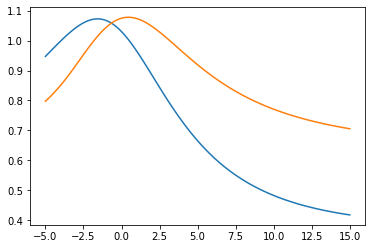

In [459]:
plot_frontier(ret, bm, msci, ante = True, aware=False)
plot_frontier(ret, bm, msci, ante = True, aware=True)

/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/joe/miniconda3/envs/esg-frontier/lib/python3.10/site-packages/numpy/core/_methods.py:

<AxesSubplot:>

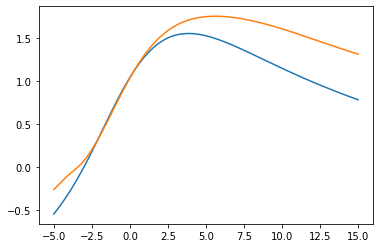

In [457]:
plot_frontier(ret, bm, msci, ante = False, aware=False)
plot_frontier(ret, bm, msci, ante = False, aware=True)

In [350]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])